
<center><b><font size="5">Neural net fit to CLAS DVCS data and the resulting D-term and its uncertainty</font></b></center><br>
This is the jupyter/python code used for production of paper by K. Kumerički, <i>Measurability of pressure distribution inside the proton</i>, to be published by Nature as "matters arising" from the paper by Burkert, V. D., Elouadrhiri, L. and Girod, F. X., <i>The pressure distribution inside the proton</i>, Nature, <b>557</b> 396-399 (2018).

# Software initialization

Jupyter initialization:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Standard python packages:

In [2]:
import shelve, logging, sys, copy
logging.basicConfig(level=logging.ERROR)
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# We want nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{amssymb}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

GeParD GPD code (not public yet) implementing Belitsky and Müller DVCS formulas and interface to PyBrain neural net software.

In [4]:
GEPARD_DIR = '/home/kkumer/gepard'
sys.path.append(GEPARD_DIR+'/pype')
import Model, Approach, Fitter, Data, utils, plots
from results import *
from abbrevs import *
from constants import Mp2, toTeX

We also load model databases:

In [5]:
db = shelve.open(GEPARD_DIR+'/pype/theories.db')   # standard KM fits etc.
dbn = shelve.open(GEPARD_DIR+'/pype/nnnat.db')     # NNet fits done for this work

In [6]:
th15 = db['KM15']
th12 = db['KMM12']

# Formulae: D-term, subtraction constant, pressure

## Definitions

First the definitions. We are concerned with three closely related quantities:

1. GPD D-term  $D(\alpha, t)$

This is the extra term in the double-distribution GPD represenatation, with support in ERBL region only:

$$ H^{a}(x,\eta, t) = \cdots + \theta(-\eta < x < \eta)\: D^{a}\left(\frac{x}{\eta}, t\right)
\qquad a = q,g$$

2. Gravitational form factor $d_1(t)$

$$ \langle p' | T^{a}_{\mu\nu}(0) | p \rangle = u'\Big(\cdots + d^{a}_1(t)
\frac{\Delta_{\mu}\Delta_{\nu} - g_{\mu\nu}\Delta^2}{5 m}\Big) u
$$

which is often redefined as $D(t)\equiv \frac{4}{5} d_{1}(t)$, and often also called D-term. 

3. Compton form factor subtraction constant $\Delta(t)$

$$
\Re e\,\mathcal{H}(\xi,t) = \frac{1}{\pi} {\rm P.V.}
\int_{0}^{1} dx \left(\frac{1}{\xi-x} - \frac{1}{\xi+x}\right)\Im m\,\mathcal{H} (\xi,t)
+ \Delta(t)
$$

## Relations

These quantites are related. First by Gegenbauer expansion of GPD D-term

$$
D^{a}(\alpha, t) = (1-\alpha^2) \sum_{n,{\rm odd}} d_{n}^a C_{n}^{(3/2)}(\alpha)
$$

Also, with the help of LO QCD factorization formula expressing CFFs as integrals over GPDs,

$$
\Delta(t) = 2 \sum_q Q_{q}^2 \int_{-1}^{1} d\alpha \frac{D_{q}(\alpha, t)}{1-\alpha}
= 4\sum_q Q_{q}^2 \big(d_{1}^q(t) + d_{3}^q(t) + \cdots\big)
$$

Additionally, coefficient of highest power in odd Mellin moment of GPD

$$
\int_{-1}^1 x^n H^{a}(x,\eta,t) = \cdots + \eta^{n+1} h^{a(n)}_{n+1}
$$

is related to GPD D-term

$$
 h^{(n)}_{n+1} = \int_{-1}^{1} d\alpha\, \alpha^n D(\alpha, t)
$$

and, in particular,

$$
h_{2}^{(1)}  = \frac{4}{5} d_1
$$

## Pressure distribution

Pressure distribution resulting from D-term is (see e.g. Eqs. (29a) and (35b) in arXiv:[1805.06596](https://www.arXiv.org/abs/1805.06596)):

$$
p(r) = \frac{1}{24 \pi^2 m} \int_{-\infty}^0 dt \, \frac{\sin(r \sqrt{-t})}{r}\, t D(t)
$$

This is in principle valid only for total quark+gluon system.

To obtain $p(r)$ from DVCS, which provides access only to subtraction constant $\Delta(t)$, one thus needs several assumptions.

1. Forget about gluons. From DIS/PDF experience there are about one third of gluons at average $x_{\rm B}$ of CLAS kinematics. At LO, they don't contribute to DVCS much, so one can assume that $\Delta(t)$ is dominantly coming from quarks. To talk about "quark pressure" one also needs to neglect energy-momentum flow from quarks to gluons described by EMT form factor $\tilde{c}(t)$. This assumption can be supported by recent results by Polyakov and Son within instanton liquid model where contribution of $\tilde{c}(t)$ is less than 20% of quark D-term. (Lattice will also have results about this soon.)

2. Forget about strange and heavier quarks. O.K. more or less.

3. Neglect higher terms in Gegenbauer expansion ($d_{3}(t)$, $d_{5}(t)$, ...). This is to some extent supported by ChiQSM results and should be good assumption for large $Q^2$ (EIC!) because QCD evolution kills all Gegenbauer moments apart from the first one.

Under these assumptions one obtains the relation

$$
\Delta(t) = 4 \left( \frac{4}{9} d_{1}^{u}(t) + \frac{1}{9} d_{1}^{d}(t) \right)
$$

To compare with results of quark models, one needs some assumption on u-d flavour structure. Maxim/Peter propose to rely on large-$N_c$ limit $d_{1}^u = d_{1}^{d} = d_{1}^{Q}/2$ which leads, for $D^{Q}(t)\equiv \frac{4}{5} d^{Q}_{1}(t)$, to
 
$$
D^{Q}(t) = \frac{18}{25} \Delta(t) \:.
$$

Alternatively, one could follow assumptions of KM parametrization $d_{1}^u = 2 d_{1}^{d} = 2 d_{1}^{Q}/3$, which leads to

$$
D^{Q}(t) = \frac{3}{5} \Delta(t)
$$

Two approaches differ less than 20% which is not so important at the level of present phenomenology.

# Neural net fit to CLAS 2015 (and 2007) data

## CLAS datasets

Data that is used by Bukert et al. is CLAS 2015 data on unpolarized DVCS cross-section:

In [7]:
utils.listdata([98,100], data)

[ 98]     CLAS 2640       BSS 1504.02009 CLAS data base E145M1
[100]     CLAS 1152       BSS 1504.02009 CLAS data base E145M1, restricted kinematics


where in `ID=100` dataset we removed some problematic points (such as those with very low $Q^2$). This set is what is used for e.g. `KM15` global fits

Also used is older 2007 beam spin asymmetry data:

In [8]:
utils.listdata([7], data)     # analysis by CLAS

[  7]     CLAS  62       BSA  0711.4805 private table


... while the newer polarized DVCS cross-section data 

In [9]:
utils.listdata([97,99], data)

[ 97]     CLAS 2640       BSD 1504.02009 CLAS data base E145M2
[ 99]     CLAS 1152       BSD 1504.02009 CLAS data base E145M2, restricted kinematics


only seems to be used by Burkert et al. for consistency checks (since it is not statistically independent from old BSA data).

For some fits and plots below, also harmonics (Fourier transforms) of the above data are used:

In [10]:
utils.listdata([101,102], data)

[101]     CLAS  48      BSDw 1504.02009 FT analysis with MC error propagation by KK
[102]     CLAS  96      BSSw 1504.02009 FT analysis with MC error propagation by KK


In [11]:
utils.listdata([8], data)

[  8]     CLAS  12       BSA  0711.4805 F.T. by DM


We transform some datasets to pandas frames for easier manipulations

In [12]:
BSA = data[7].df()   # ALU(90 deg) by CLAS 2007
BSS = data[102].df()  # CLAS 2015
BSD = data[101].df()  # CLAS 2015

In [13]:
BSDphi = data[97].df()   # unrestricted CLAS 2015, phi-dep

Bins can be defined as ranges within the following limiting values:

In [14]:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

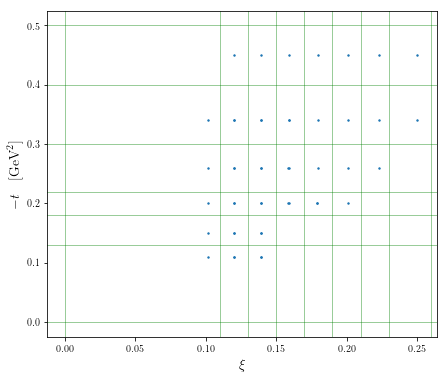

In [15]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSD.xi, BSD.tm, s=2)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
fig.savefig('figs/bins.pdf')

Old 2007 data offers also one low $\xi \sim 0.05$ bin which seems to be used in BEG Nature paper:

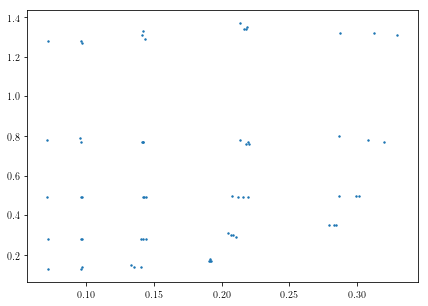

In [16]:
plt.scatter(BSA.xi, BSA.tm, s=2)

Note that for global fits we removed some extreme data from 2015 CLAS dataset. The complete dataset has also some additional low $\xi$ data:

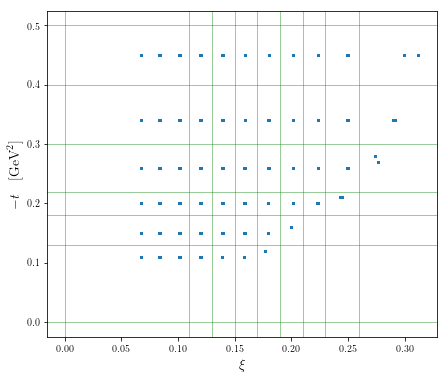

In [17]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSDphi.xi, BSDphi.tm, s=2)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
fig.savefig('figs/bins.pdf')

## Fits

To determine uncertainties, we do the neural net fit to CLAS 2015 BSS and BSD (or 2008 BSA) data. We work with multilayer perceptrons provided by publicly available package `pybrain`. Architecture of nets parametrizing imaginary part of CFF is:
   * two input neurons (for $x_{\rm B}$ and $t$)
   * seven neurons in hidden layers
   * one neuron in the output layer for each required imaginary part of CFF
   
Architecture of nets parametrizing subtraction constants is:
   * one input neuron (for $t$)
   * three neurons in hidden layers
   * one neuron in the output layer for each required subtraction constant
   
Real part of CFFs is then determined by dispersion relations, then from total CFFs observables are calculated using Belitsky and Müller formulas, and they are compared to data (chi^2), where error is back-propagated and used for network training.

We performed relevant checks and convinced ourselves that results don't depend significantly on the details of net architecture i.e. number and size of hidden layers.

In [18]:
DONN = False   # We did the fits below once and saved it

In [19]:
if DONN:
    # Model creation
    mNN = Model.ModelNN(output_layer=['ImH', 'ReH'], useDR=['ReH'])
    tNN = Approach.BM10tw2(mNN)
    fNN = Fitter.FitterBrain(data[101] + data[102], tNN, nnets=1, nbatch=10)
    fNN.fitgood()

When code above is run, result is like:

`[  1/999] Net  1 ---> TestError:    0.394  ---> P(chisq = 86.23) = 1.0000`

which means that we trained one net which has chi^2/npts = 86.23/144.

The code above is just for demonstration purpose. Using  batch scripts, we performed more extensive neural net fits, training 10 or 80 neural nets, and with various choices for number of CFFs used. This took few weeks of CPU  and results are stored in a database of models:

In [20]:
utils.listdb(dbn)

-------------------+--------------------------------------------------------------
name               |  description
-------------------+--------------------------------------------------------------
NNDR-C15-2         |  10 NNs C15 13.8/36 p=1
NNDR-C15_ALUI-4    |  10 NNs C15+ALUI 18.8/42 p=0.999
NNDR-C15+BSA-4t    |  10 NNs C15+BSA 18.8/36 p=0.992
NNDR-C15-BSA-4t    |  10 NNs C15+BSA 17.1/36 p=0.997
NNDR-C15+BSA-2     |  10 NNs C15+BSA 15.8/36 p=0.999
NNDR-C15-BSA-2     |  10 NNs C15+BSA 15.9/36 p=0.999
NNDR-C15_ALUI-4t   |  10 NNs C15+ALUI 31.8/42 p=0.875
NNDR-C15BSA-8      |  10 NNs C15+BSA 17.5/36 p=0.996
NNDR-C15-6         |  10 NNs C15 18.5/36 p=0.993
NNDR-C15+BSA-8     |  10 NNs C15+BSA 19.5/36 p=0.989
NNDR-C15-BSA-8     |  10 NNs C15+BSA 23.8/36 p=0.941
NNDR-C15-4         |  10 NNs C15 14.6/36 p=0.999
NNDRL-C15_ALUI-4   |  80 NNs C15+ALUI 21.7/42 p=0.996
NNDR-C15_BSA-8     |  10 NNs C15+BSA  16.1/36 p=0.998
NNDR-C15-4t        |  10 NNs C15 18.1/36 p=0.994
NNDR-C15_ALUI-8    | 

Name of the fit/model is constructed in the following way. First `NNDR` means that neural net fits are performed with dispersion relations (DR) constraint active. Then training datasets are named `C15` for CLAS 2015 data, `BSA` for CLAS 2007 data and `ALUI` for HERMES $A_{\rm LU, I}$. Finally, number of CFFs used is given (2-8). Particular CFFs are:

In [21]:
for key in dbn:
    th = dbn[key]
    print("{:18s} |  {}".format(th.name, th.m.output_layer))

NNDR-C15-2         |  ['ImH', 'ReH']
NNDR-C15_ALUI-4    |  ['ImH', 'ReH', 'ImE', 'ReE']
NNDR-C15+BSA-4t    |  ['ImH', 'ReH', 'ImHt', 'ReHt']
NNDR-C15-BSA-4t    |  ['ImH', 'ReH', 'ImHt', 'ReHt']
NNDR-C15+BSA-2     |  ['ImH', 'ReH']
NNDR-C15-BSA-2     |  ['ImH', 'ReH']
NNDR-C15_ALUI-4t   |  ['ImH', 'ReH', 'ImHt', 'ReHt']
NNDR-C15BSA-8      |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDR-C15-6         |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt']
NNDR-C15+BSA-8     |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDR-C15-BSA-8     |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDR-C15-4         |  ['ImH', 'ReH', 'ImE', 'ReE']
NNDRL-C15_ALUI-4   |  ['ImH', 'ReH', 'ImE', 'ReE']
NNDR-C15_BSA-8     |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDR-C15-4t        |  ['ImH', 'ReH', 'ImHt', 'ReHt']
NNDR-C15_ALUI-8    |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDRL-C15-4        |  ['ImH', 'ReH', 'ImE'

## Analysis of results and determination of D-term

To obtain the uncertainty bands, one averages over all nets of a given model. For example, all nets of CFF-H-only model:

In [22]:
th = dbn['NNDR-C15-2']

In [23]:
ths = []
for k in range(len(th.m.nets)):
    tha = copy.deepcopy(th)
    #tha.name = '{}-{}'.format(k, tha.name)
    tha.name = None
    tha.m.parameters['nnet'] = k
    ths.append(tha)

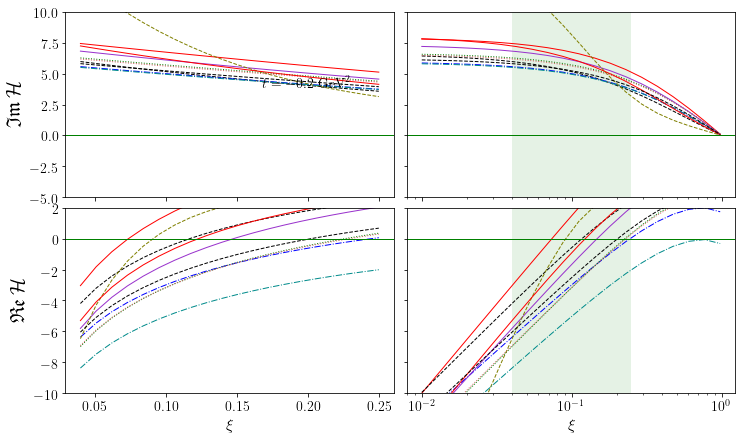

In [24]:
fig = plots.CFF(lines=ths, cffs=['ImH', 'ReH'])

In [25]:
fig.savefig('figs/NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

This is then averaged to become:

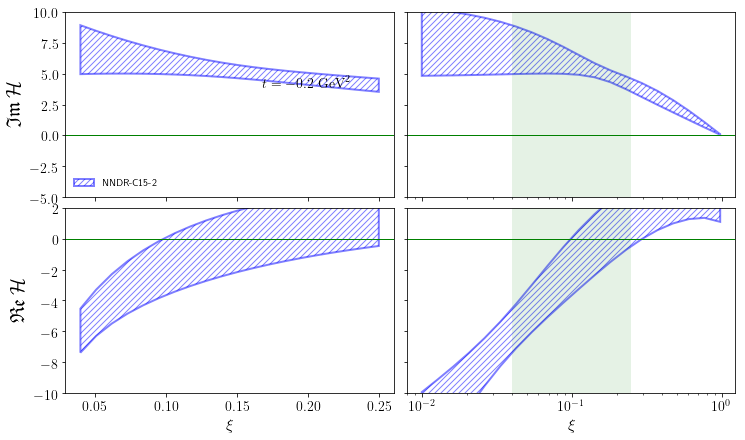

In [26]:
fig = plots.CFF(bands=[th], cffs=['ImH', 'ReH'])

In [27]:
fig.savefig('figs/NNDR.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

To demonstrate that 10 neural nets are enough to reach sensible accuracy, we compare CFF $\mathcal{H}$ as obtained with 10 and with 80 neural nets trained on CLAS 2015 data, labeled as `NNDR-C15-4` and `NNDRL-C15-4`, respectively:

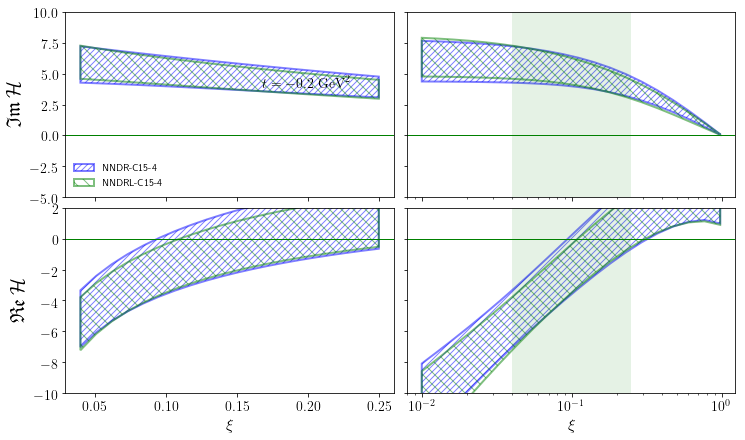

In [28]:
fig = plots.CFF(bands=[dbn['NNDR-C15-4'], dbn['NNDRL-C15-4']], cffs=['ImH', 'ReH'])

This is close enough, so the rest of the analysis will be done with 10 NNets per model, for the reasons of speed (it takes a day or so of CPU time to produce 10 NNets).

Fits are actually performed in harmonics space. To convince oneself that fit is good, let's  see $\chi^2/{\rm d.o.f.}$ in both $\phi$-space and in harmonics space:

In [29]:
# This one takes 14 mins, result is: P(chi-square, d.o.f) = P(1725.08, 2028) = 1.0000
# %%time
# th.print_chisq(utils.select(data[99]+data[100], criteria=['err > 0']))

In [30]:
%%time
th.print_chisq(data[101]+data[102])

P(chi-square, d.o.f) = P(51.09, 144) = 1.0000
CPU times: user 1min 4s, sys: 6.6 ms, total: 1min 4s
Wall time: 1min 4s


And, for a good measure, some plots of observables (NN fits w.r.t. actual experimental data) also in $\phi$ and in harmonic space:

/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


CPU times: user 1min 8s, sys: 103 ms, total: 1min 8s
Wall time: 1min 8s


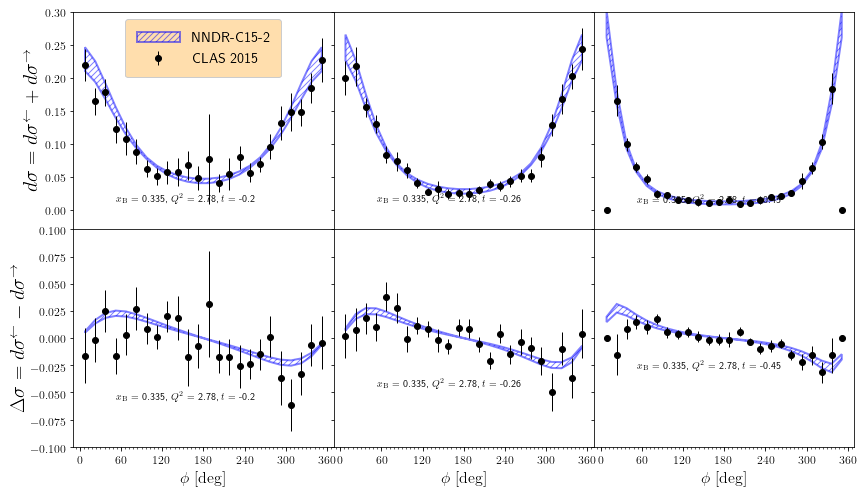

In [31]:
%%time
fig = plots.CLAS15phi(bands=[th])

In [32]:
fig.savefig('figs/NNDR-CLAS15phi.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


CPU times: user 53.5 s, sys: 16.6 ms, total: 53.5 s
Wall time: 53.6 s


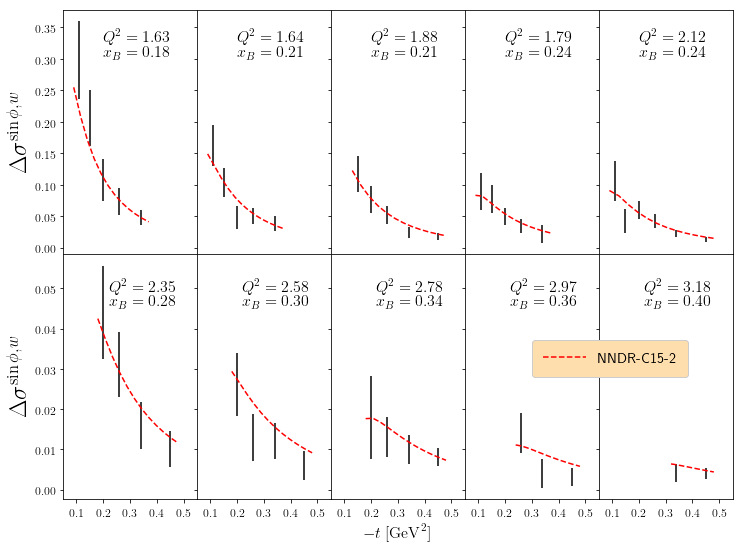

In [33]:
%%time
figw = plots.CLAS15xs(lines=[th])

In [34]:
figw.savefig('figs/NNDR-CLAS15.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

To see the dependence of extracted CFF $\mathcal{H}$ on assumption wheter other CFFs contribute or not, let's compare fits with only-$\mathcal{H}$ model to fit with all LO twist-2 CFFs ($\mathcal{H}$, $\mathcal{E}$, $\tilde{\mathcal{H}}$, $\tilde{\mathcal{E}}$):

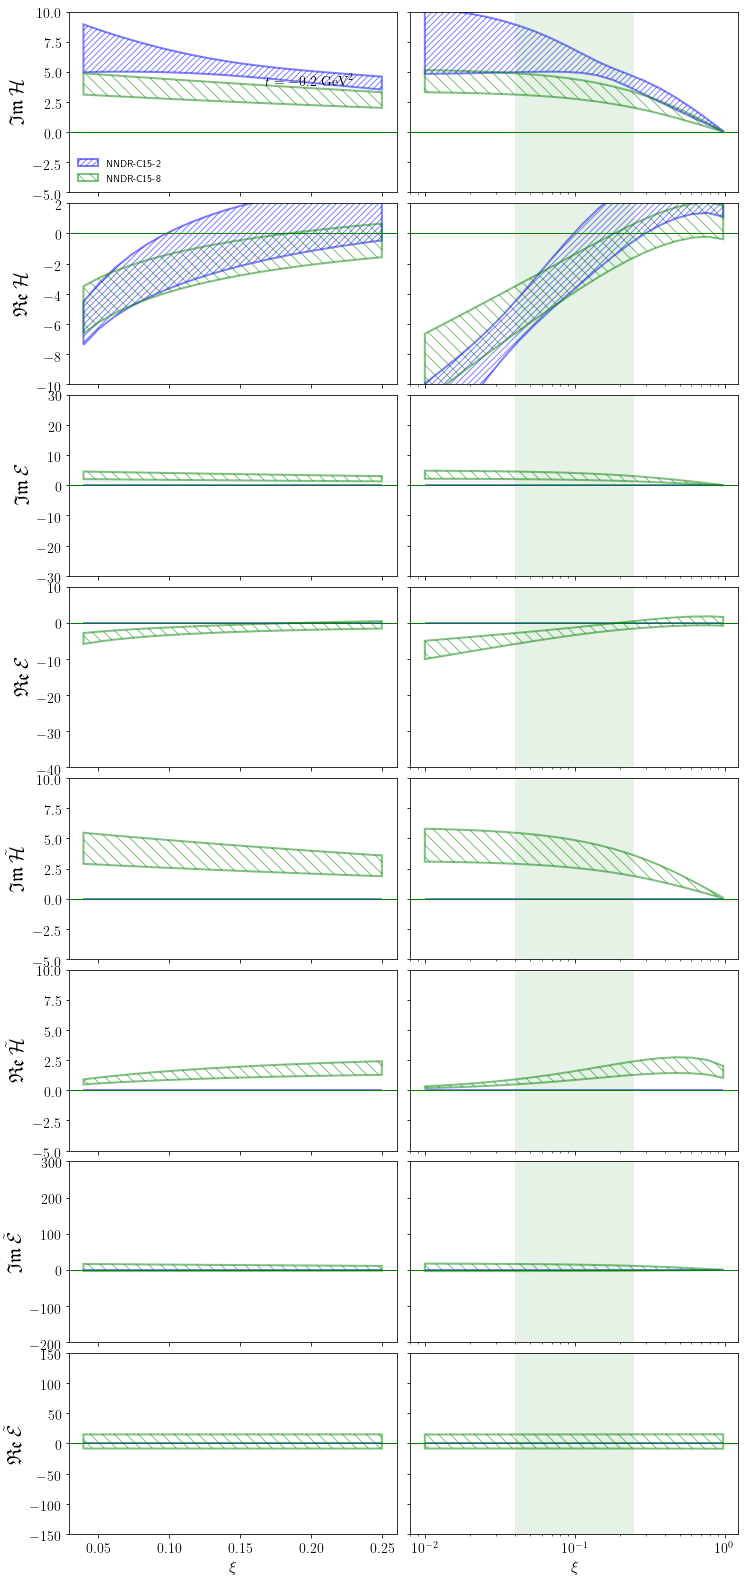

In [35]:
fig = plots.CFF(bands=[dbn['NNDR-C15-2'], dbn['NNDR-C15-8']], cffs=['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])

In [36]:
fig.savefig('figs/NNDR-8.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

One notices significant shift in $\Im m \mathcal{H}$, in contrast to very narrow gray bands in Burkert et al.

Finally, let's see resulting values of D-term, for these same two models. Here "D-term" is $D(t)$ from most of the recent Maxim's papers, which is equal to $\frac{4}{5} d_{1}(t)$

In [37]:
ptts = []
for tm in [0.1, 0.2, 0.3, 0.4]:
    ptb = data[102][5].copy()  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)

In [38]:
D = []
for th in [dbn['NNDR-C15-2'], dbn['NNDR-C15-8']]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for k in range(len(th.m.nets)):
            th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            Ds.append(-th.m.subtraction(pt)*18./25.)
        Ds = np.array(Ds)
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'
    D.append(A)


---- [NNDR-C15-2 - 10 NNs C15 13.8/36 p=1] ----
0.214, -0.4: 1.5856189717243319 +- 1.458966049067359
0.214, -0.3: 1.596424169073643 +- 1.4364566197333795
0.214, -0.2: 1.607818471515254 +- 1.4158461013614236
0.214, -0.1: 1.6190998841786381 +- 1.3969299103566184

---- [NNDR-C15-8 - 10 NNs C15 18.1/36 p=0.994] ----
0.214, -0.4: 0.09908838740305873 +- 0.8136955373618655
0.214, -0.3: 0.09240562525601323 +- 0.8018944846101325
0.214, -0.2: 0.08658636386306401 +- 0.7935306863477304
0.214, -0.1: 0.08152173179815342 +- 0.7894010945188727


In [39]:
np.array(D[1]).mean(axis=0)*(25./18.)

array([0.34722222, 0.12486184, 1.11059785])

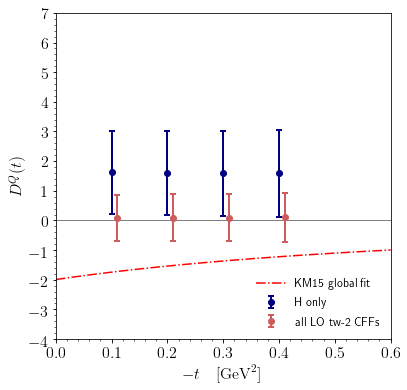

In [40]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H only')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='all LO tw-2 CFFs')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4, 7)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

Now the same but using fits where 2007 BSA data are used instead of 2015 BSD data

In [41]:
D = []
for th in [dbn['NNDR-C15-BSA-2'], dbn['NNDR-C15-BSA-8']]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for k in range(len(th.m.nets)):
            th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            Ds.append(-th.m.subtraction(pt)*18./25.)
        Ds = np.array(Ds)
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'
    D.append(A)


---- [NNDR-C15-BSA-2 - 10 NNs C15+BSA 15.9/36 p=0.999] ----
0.214, -0.4: 0.02220517198281685 +- 0.8261505957533729
0.214, -0.3: 0.3840971579696945 +- 0.6996212529510549
0.214, -0.2: 0.9902291965165363 +- 1.021372893603848
0.214, -0.1: 2.030854925393341 +- 2.0084423575191286

---- [NNDR-C15-BSA-8 - 10 NNs C15+BSA 23.8/36 p=0.941] ----
0.214, -0.4: 0.571422319548775 +- 1.1161434553260128
0.214, -0.3: 0.5437898686165601 +- 1.0071619466582549
0.214, -0.2: 0.4998359453556855 +- 0.7525364348021889
0.214, -0.1: 0.6275200535530935 +- 1.4306584209329245


In [42]:
np.array(D[1]).mean(axis=0)*(25./18.)

array([0.34722222, 0.77866951, 1.49531259])

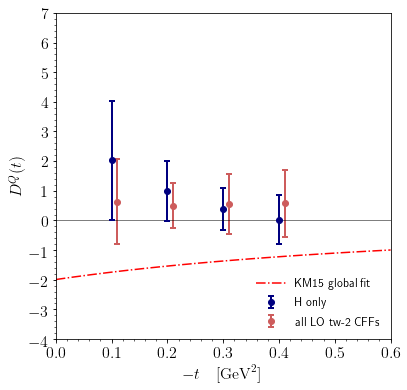

In [43]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H only')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='all LO tw-2 CFFs')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4, 7)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

One notices that CLAS 2015 data actually prefer slightly positive D-term (but are consistent with negative one, which is expected from the stability criterion). It is interesting to compare this to preliminary JLab **timelike** DVCS measurement, arXiv:[1302.3088](http://arxiv.org/abs/arXiv:1302.3088), which also seems to prefer positive D-term. As demonstrated by KM fits, after including data from other experiments (HERMES, Hall A, CLAS target asymmetries), negative D-term is preferred as it should be.

# Pressure distribution

## Code for  pressure in terms of D-term

<b>Note:</b> In formulas here "D-term" is $D(t)$ from most of the recent Maxim's papers, which is equal to $\frac{4}{5} d_{1}(t)$.

In [44]:
def Dterm(t, D0=-1.6, M=0.7, p=3):
    """D-term parametrization"""
    return D0/(1-t/M**2)**p

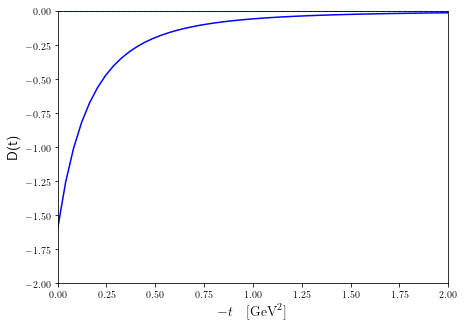

In [45]:
# Plotting this D-term
fig, ax = plt.subplots(1, 1, figsize=[7,5])
tms = np.linspace(0,2)
ax.plot(tms, Dterm(-tms), 'b-')
ax.set_ylabel(r'D(t)', fontsize=14)
ax.set_xlabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-2,0)
fig.savefig('figs/dterm.pdf')

Note that D-term is dimensionless, while dimension of pressure in natural units is GeV$^4$, so $r^2 p(r)$ is GeV$^2$. We will divide by 0.197 to get result in GeV/fm instead.

In [46]:
def pressureNnaive(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [47]:
def pressureN(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    # variable change x=-t^2, so QUADPACK Fourier integral method can be used
    intg = quad(lambda x: 2*x*(-x**2)*Dterm(-x**2, **args), 0, np.inf, weight='sin', wvar=rGeV)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

Integral involved here can be somewhat numerically demanding due to oscillatory behaviour of integrand and slow decay for large $-t$, but it can be performed analytically for cases $p=2,3$, which is convenient for doing checks on numerical routines below:

In [48]:
def pressureA(r, D0=-1.6, M=0.7, p=3):
    """Pressure distribution r^2*p(r) in GeV/fm for specific Dterm(t) function
    
     D(t) = D0/(1-t/M^2)^p  with p=2 or 3
    
    """
    GeVfm = 0.197
    Mp = 0.938
    assert p in [2,3]
    rGeV = r/GeVfm
    res = D0 * M**(2+p) * rGeV**(p-3) * np.exp(-M*rGeV) * (M*rGeV - p)
    return rGeV**2 * res / (2**(2*p) * 3 * np.pi * Mp) / GeVfm

In [49]:
D0val, Mval, pval = -1.6, 0.7, 3
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/usr/lib/python3.7/site-packages/ipykernel/__main__.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


(0.0037265359461670666, 0.003726545962032528, 0.00372653594438695)

For fast decaying integrand, $\propto (1-t/M^2)^3$, all methods agree.

In [50]:
D0val, Mval, pval = -1.6, 1.3, 2
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/usr/lib/python3.7/site-packages/ipykernel/__main__.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.


(0.0007003436725664407, -0.027815739561061346, 0.0007003436730263116)

For slowly converging integrand (smaller power of D-term denominator) naive integration fails. So we use better numerical method from now on:

In [51]:
pressure = pressureN

## Pressure distribution - mean values

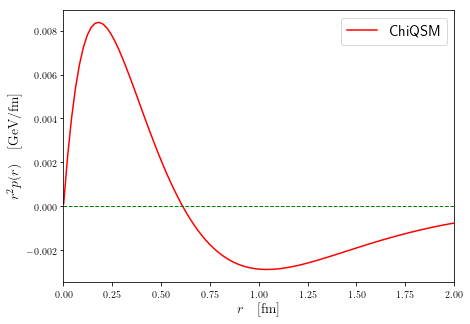

In [52]:
# Plotting the distribution for ChiQSM parameters from hep-ph/0702030
# d_1(0) = -2.35, M = 0.646,  so D(0) = 1.88
fig, ax = plt.subplots(1, 1, figsize=[7,5])
rs = np.linspace(0.001,2,100)
ps = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=-1.88, M=0.646, p=2))
ax.plot(rs, ps, 'r-', label='ChiQSM')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
fig.savefig('figs/pressure.pdf')

This is in perfect agreement with Fig. 4 of hep-ph/0702030. 

Let's now plot the same for Parameters from Burkert et al., Nature. Here, there is some confusion about what is their $d_{1}$. Numbers from Burkert's presentation on Grips QCD workshop seem to imply that $D^{Q}(0) = \frac{18}{25} d_{1}^{Q}(0)$, which would mean that $d_{1}$ in Nature paper is actually equal to subtraction constant $\Delta(t)$. OTOH, Maxim and Peter naturally plot $d_{1}$ assuming it is equal to usual gravitational form factor, as defined above. There also seems to be a possibility, see below, that charge prefactor $\sum_q Q_{q}^2 = 5/9$ is missing somewhere.

Let's plot pressure distribution under these two different assumptions:

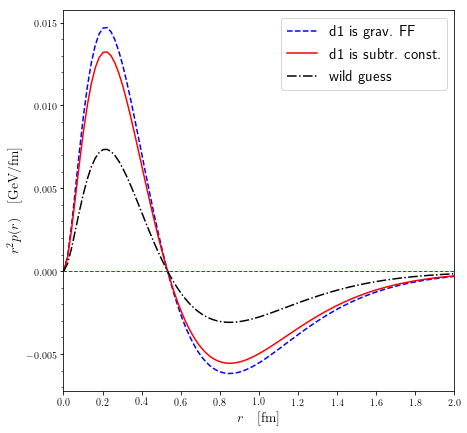

In [53]:
Mval = np.sqrt(1.06)
D0val = -2.04 * (4./5.) # d_1 is grav. form. fact.
D0valA = -2.04 * (18./25.)  # d_1 is subtr. const
D0valB = -2.04 * (18./25.)*(5./9.)  # wild guess
fig, ax = plt.subplots(1, 1, figsize=[7,7])
rs = np.linspace(0.001,2,100)
ps = []
psA = []
psB = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=D0val, M=Mval, p=2.76))   
    psA.append(pressure(r, Dterm, D0=D0valA, M=Mval, p=2.76))
    psB.append(pressure(r, Dterm, D0=D0valB, M=Mval, p=2.76))
ax.plot(rs, ps, 'b--', label='d1 is grav. FF')
ax.plot(rs, psA, 'r-', label='d1 is subtr. const.')
ax.plot(rs, psB, 'k-.', label='wild guess')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
fig.savefig('figs/pressure.pdf')

I assume there is a typo in the Nature (where y-axis is labeled with $10^{-2}$ factor, but it should be $10^{-3}$), and Burkert's presentation on Grips QCD conference seems to confirm this typo. However, there is still roughly a factor of 2 discrepancy with Nature/Grips plots: height of first maximum there is about 0.0075, while I get about 0.015 here! This should be understood at some point. I can get almost the same curve by removing the charge factor 5/9 ("wild guess" above) but such choice would be difficult to understand.

## Pressure distribution - uncertainties

Let's add their stat and sys errors in quadrature and do very simple MC error propagation. This should be improved (MC error propagation to the numerical integral above is tricky: Gaussian is transformed into very slowly decaying asymmetric distribution).

In [54]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = np.sqrt(0.14**2 + 0.33**2) * (18./25.)*(5./9.)
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [55]:
# Sampling from Gaussian/normal distribution using scipy's stats routines
ss = 50 #  sample size
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [56]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

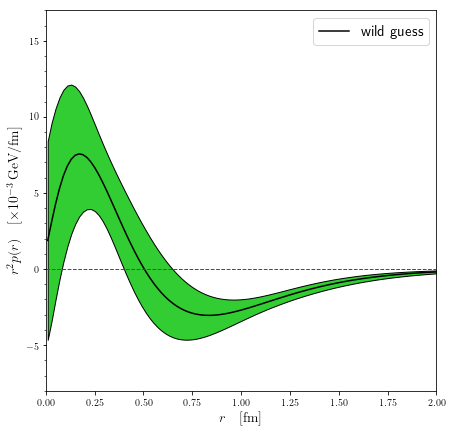

In [57]:
# I need to use "wild guess" option above to get agreement Fig. from Nature
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='limegreen',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
fig.savefig('figs/pressure_nat.pdf')

So, error propagation seems to be O.K.

We now take **uncertainties as given by Neural nets** unbiased approach (we take the $\mathcal{H}$-only model `NNDR-C15-2` as Burkert at al.), while keeping their functional form and (maybe erroneous?!) mean values for D-term.

In [58]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = 1.4 * (18./25.)  # as seen above, this is essentially t-independent
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [59]:
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [60]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

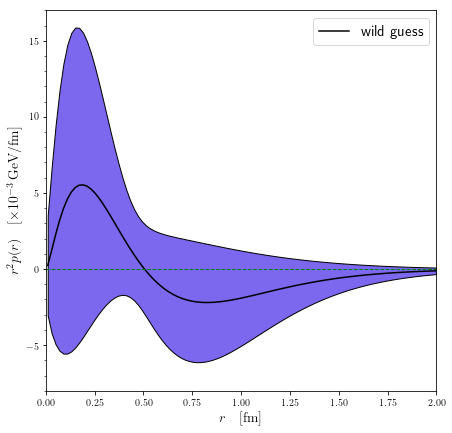

In [61]:
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='mediumslateblue',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
fig.savefig('figs/pressure_NNet.pdf')

So, even if we would agree with mean value of D-term as extracted by Burkert et al., uncertainties are much larger, making pressure consistent with zero everywhere. If we also take into account mean value of D-term as extracted by this neural net fit (which is positive!), we are even further at odds from Burkert et al. result. So, with realistic uncertainty coming from unbiased neural net procedure, we still **cannot detect quark pressure** from present CLAS BSS, BSD/BSA data **alone**.

# Successful KM  fit  to CLAS  with D(t)=0

Alternative way to convince onself that CLAS 2015 data alone doesn't conclusively imply non-zero pressure is via fitting this data using parametrization with zero subtraction constant. It turns out that this is possible using old `KM09a` parametrization from arXiv:[0904.0458](http://arxiv.org/abs/arXiv:0904.0458), using same values for parameters as there, but setting subtraction constant to zero. This is easy to check for everybody since `KM09a` parametrization is simple analytic function that also for sea partons uses the same "KM" parametrization of $\Im m \mathcal{H}$ (and not conformal moment space sea modelling like e.g. `KM15`).

In [62]:
th09azero = copy.deepcopy(db['KM09a'])  # Loading from model database
th09azero.name = 'KM09a($\Delta=0$)'

In [63]:
th09azero.m.parameters.update({'C':0})  # Setting D-term to zero

There is also a pion pole contribution to $\Re e\tilde{\mathcal{E}}$ in original `KM09a`., It is actually numerically insignificant for present analysis. For consistency, we now also set it to zero by hand (so that only $\mathcal{H}$ contribution remains), but one gets essentially the same chi-square and plots with and without it.

In [64]:
def zero(pt):
    return 0

In [65]:
th09azero.m.ReEt = zero

In [66]:
# The result of actual MINUIT fit to CLAS 2015 xs data 
#   (but not needed since it's very close)
# th09zero.m.parameters.update({'C':0, 'bS':3.249, 'rv':1.131, 'bv':0.463})

That fit is good can be seen from $\chi^2$ in $\phi$-space:

In [67]:
th09azero.print_chisq(utils.select(data[99]+data[100], criteria=['err > 0']))

P(chi-square, d.o.f) = P(1751.39, 2023) = 1.0000


and in space of harmonics:

In [68]:
th09azero.print_chisq(data[101]+data[102])

P(chi-square, d.o.f) = P(57.68, 139) = 1.0000


and from the plots in $\phi$-space:

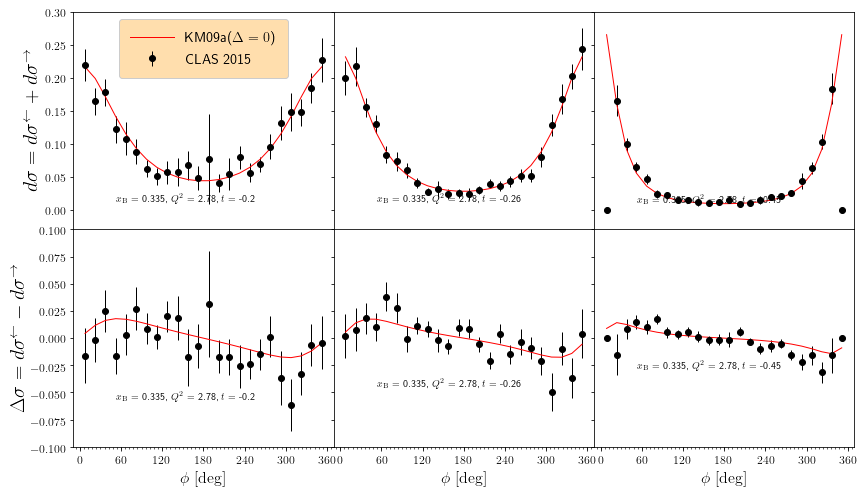

In [69]:
fig = plots.CLAS15phi(lines=[th09azero])

In [70]:
fig.savefig('figs/th09azero.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

and in the space of harmonics:

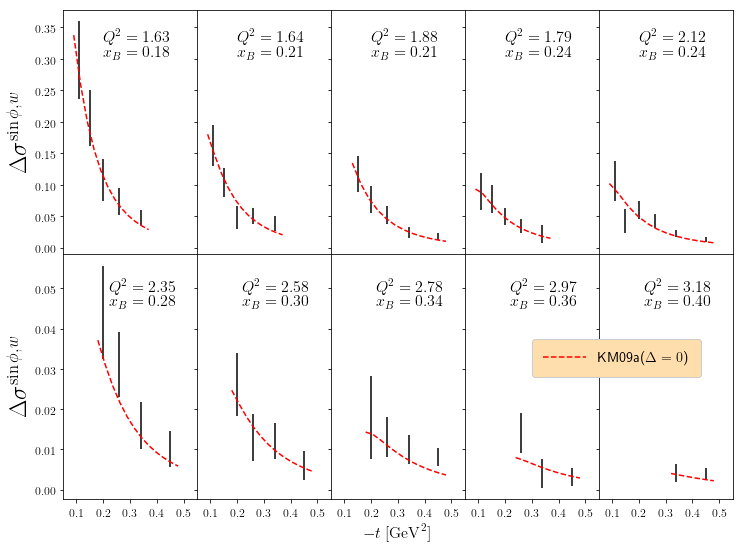

In [71]:
figw = plots.CLAS15xs(lines=[th09azero])

In [72]:
figw.savefig('figs/th09azerow.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

Additionally, old BSA CLAS result (with smaller systematics) is also described reasonably (but not perfect):

In [73]:
nonz = utils.select(data[6], criteria=['err > 0'])

In [74]:
th09azero.print_chisq(nonz)

P(chi-square, d.o.f) = P(989.89, 732) = 0.0000


So total chi-square is in this BSS+BSA case (which is what BEG use):

In [75]:
nonz_total = utils.select(data[6]+data[100], criteria=['err > 0'])

In [76]:
th09azero.print_chisq(nonz_total)

P(chi-square, d.o.f) = P(1784.66, 1746) = 0.2544


# (Appendix) Local fit to CLAS 2015 data

## Reminder how local fits are done (HERMES data)

Our main point are uncertainties, as provided by neural network fits, but since we also find some discrepancies in mean values, let's do some fast local least-squares fits as well. As a warm-up, we reproduce our own local fit to HERMES data so that we remind ourselves of the local fit procedures.

In [77]:
# Updated 4-t-bin data by Morgan
bins = list(zip(L4_ALUI, L4_AC_1, L4_AUL, L4_ALL_1,
           L4_AUTI_1, L4_AUTI_m1, L4_ALTI_1, L4_ALTI_m1))

In [78]:
totchi = 0
ndof = 0
sys.stdout.write('-- Bin: ')
CFFs = ['pImH', 'pReH', 'pImHt']
CFFvals = []
CFFerrs = []
for nbin in range(len(bins)):
    # Model creation
    m = Model.ModelLocal()
    m.parameters['pImH'] = 10.
    th = Approach.BM10(m)
    th.name = 'local-bin-%2s' % (nbin+1,)
    th.model.fix_parameters('ALL')
    th.model.release_parameters(*CFFs)
    # Fit to data in given bin
    sys.stdout.write('%2s .. ' % (nbin+1,))
    f = Fitter.FitterMinuit(bins[nbin], th)
    #f.printMode = 2
    f.fit()
    totchi += th.chisq(f.fitpoints)[0]
    ndof += len(f.fitpoints)-len(CFFs)
    vals= []
    errs = []
    for p in CFFs:
            vals.append(th.m.parameters[p])
            errs.append(np.sqrt(th.m.covariance[p,p]))
    CFFvals.append(vals)
    CFFerrs.append(errs)
    
CFFvals = np.array(CFFvals)
CFFerrs = np.array(CFFerrs)

print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))

-- Bin:  1 .. 

FCN = 5.1418057369793315 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 4.373231362807061e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,25.1537,3.12118,,,,,No
1,pReH,-0.38971,0.446035,,,,,No
2,pImHt,-1.63151,3.23302,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 2 .. 

FCN = 2.583863279494243 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 1.0205157195470886e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,9.53202,1.86265,,,,,No
1,pReH,-1.17005,0.517602,,,,,No
2,pImHt,0.947077,1.65545,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 3 .. 

FCN = 8.510490081161073 
 TOTAL NCALL = 51 
 NCALLS = 51 
 
 
 EDM = 9.570753968350022e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,8.47533,1.50782,,,,,No
1,pReH,-1.27465,0.489543,,,,,No
2,pImHt,1.40576,1.30789,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 4 .. 

FCN = 0.678510846137154 
 TOTAL NCALL = 82 
 NCALLS = 82 
 
 
 EDM = 3.822811592528411e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.67861,1.47406,,,,,No
1,pReH,-1.77786,0.678483,,,,,No
2,pImHt,0.794704,1.25363,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 5 .. 

FCN = 1.8267328589064753 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 2.1581005678194507e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,19.0466,7.58538,,,,,No
1,pReH,-1.18794,0.745857,,,,,No
2,pImHt,-0.657085,2.61285,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 6 .. 

FCN = 1.4114112252758744 
 TOTAL NCALL = 53 
 NCALLS = 53 
 
 
 EDM = 6.157137566304094e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,15.927,3.13204,,,,,No
1,pReH,-1.09208,0.687943,,,,,No
2,pImHt,3.23156,2.17255,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 7 .. 

FCN = 5.321703305840086 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 1.5968128854847757e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,9.97677,2.11518,,,,,No
1,pReH,-0.85994,0.295774,,,,,No
2,pImHt,-0.639751,1.64528,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 8 .. 

FCN = 6.584588434073954 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 1.4356911818082979e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,3.30738,1.09368,,,,,No
1,pReH,-0.62954,0.228838,,,,,No
2,pImHt,0.880538,1.11029,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 9 .. 

FCN = 2.4259220754952895 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 3.502613103454931e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,16.3515,6.05476,,,,,No
1,pReH,-1.01827,1.12427,,,,,No
2,pImHt,0.861662,2.13041,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


10 .. 

FCN = 1.1675439063688993 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 1.0751123763389249e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,16.3802,4.11398,,,,,No
1,pReH,-1.27485,0.726808,,,,,No
2,pImHt,1.11128,1.88528,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


11 .. 

FCN = 5.2726640726730425 
 TOTAL NCALL = 51 
 NCALLS = 51 
 
 
 EDM = 2.8628761376142872e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,11.8224,2.75233,,,,,No
1,pReH,-1.1248,0.515417,,,,,No
2,pImHt,1.15405,1.77911,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


12 .. 

FCN = 3.372459360654126 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = 4.717306660443343e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.72738,1.20841,,,,,No
1,pReH,-0.852361,0.403324,,,,,No
2,pImHt,0.0288154,1.28921,,,,,No
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes



 chisq/ndof = 44.3/60


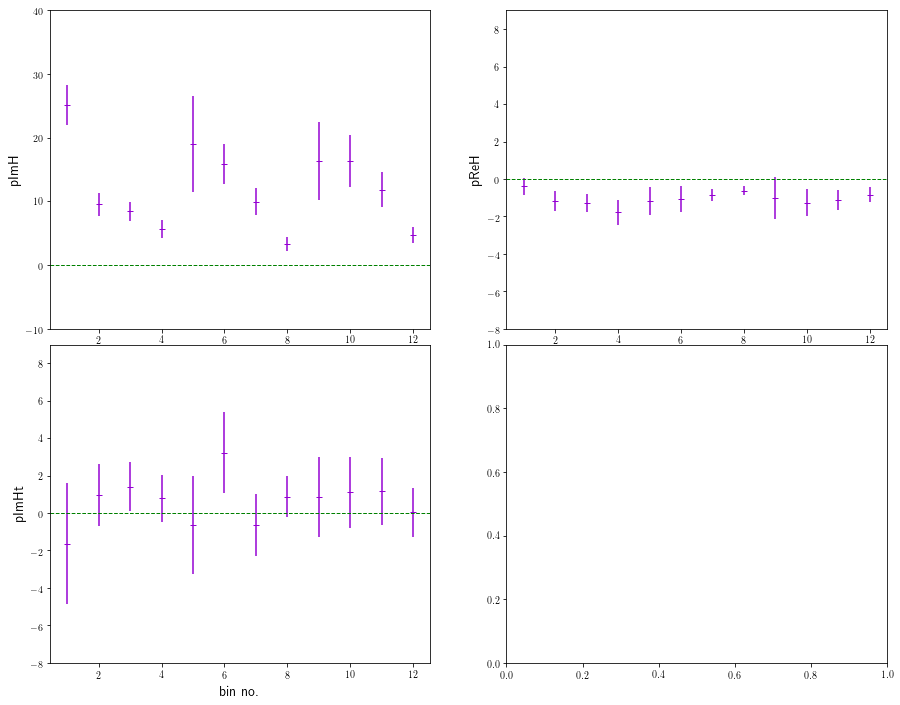

In [79]:
fig, axs = plt.subplots(2, 2, figsize=[15,12])
axs = axs.flatten()
for p in range(3):
    ax = axs[p]
    ax.errorbar(np.arange(1,13), CFFvals[:,p], CFFerrs[:,p], linestyle='None', 
                 marker='_', color='darkviolet', capsize=0)
    ax.set_ylabel(r'{}'.format(CFFs[p]), fontsize=14)
    ax.set_xlabel(r'bin no.', fontsize=14)
    ax.axhline(linestyle='--', color='g', lw=1)
axs[0].set_ylim(-10,40)
axs[1].set_ylim(-8,9)
axs[2].set_ylim(-8,9)
fig.subplots_adjust(hspace=0.05)
fig.savefig('figs/HA17bin-BSS.pdf')

This is in excellent agreement with the published plot (Fig. 6 from arXiv:[1301.1230](http://arxiv.org/abs/arXiv:1301.1230)):

![KMM12](img/hermes_local.png "Local fits to HERMES DVCS data")

## Local fit of ImH and ReH to CLAS data

In [80]:
tNN = dbn['NNDR-C15-2']  # NNet fit result, just for plotting below for comparison with local fits
tNN.m.output_layer

['ImH', 'ReH']

In [81]:
binD = {}
binS = {}
binDS = {}

In [82]:
def tmin(xB, Q2):
    """BMK Eq. (31)"""

    eps2 = (4. * xB**2 * Mp2) / Q2
    return (-Q2 * ( 2. * (1.-xB)*(1. - np.sqrt(1.+eps2)) + eps2 ) / (
            4. * xB * (1.-xB) + eps2 ))

In [83]:
def makefit(tbin, nxis): 
    """ Perform simultaneous fit of both ImH and ReH."""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        m = Model.ModelLocal()
        m.parameters['pImH'] = 10.
        th = Approach.BM10tw2(m)
        th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        th.model.release_parameters(*CFFs)
        # Fit to data in given bin
        sys.stdout.write('%2s .. ' % (xbin,))
        f = Fitter.FitterMinuit(binDS[(tbin,xbin)].pt.values, th)
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        #f.printMode = 2
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-len(CFFs)
        vals= []
        errs = []
        for p in CFFs:
                vals.append(th.m.parameters[p])
                errs.append(np.sqrt(th.m.covariance[p,p]))
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs

Stepwise fit (with ReH fitted to BSS after ImH is fixed by fit to BSD) code that follows, results in 10% smaller ReH uncertainty w.r.t. simultaneous fit using code above. This is to be expected according to bias-variance trade-off (step-wise model is more rigid i.e. biased), but effect is not too important. We will not use this stepwise fit.

In [84]:
def makefitstep(tbin, nxis):
    """ Perform step-wise fit, first ImH, then ReH ... not significant"""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        m = Model.ModelLocal()
        m.parameters['pImH'] = 10.
        th = Approach.BM10tw2(m)
        th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        sys.stdout.write('%2s .. ' % (xbin,))
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        # Fit to BSD data in given bin
        th.model.release_parameters('pImH')
        f = Fitter.FitterMinuit(binD[(tbin,xbin)].pt.values, th)
        #f.printMode = 2   
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        valImH = th.m.parameters['pImH']
        errImH = np.sqrt(th.m.covariance['pImH','pImH'])
        # Now fit to BSS data
        th.model.fix_parameters('pImH')
        th.model.release_parameters('pReH')
        f = Fitter.FitterMinuit(binS[(tbin,xbin)].pt.values, th)
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        th.model.release_parameters('pImH')
        valReH = th.m.parameters['pReH']
        errReH = np.sqrt(th.m.covariance['pReH','pReH'])
        vals= [valImH, valReH]
        errs = [errImH, errReH]
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs

In [85]:
def makefig():
    """Plot the results of the local fits together with NNet and KM fits"""
    xirange = np.linspace(0.05, 0.3, 20)
    CFFs = ['ImH', 'ReH']
    ex_pt = copy.deepcopy(pts[0])
    fig, axs = plt.subplots(1, 2, figsize=[12,6])
    for p in range(2):
        axs[p].errorbar(xis, CFFvals[:,p], CFFerrs[:,p], linestyle='None', marker='s', 
                       label='local fit')
        ys = []
        ys2 = []
        ysNN = []
        ysNNerr = []
        for xi in xirange:
            pt = ex_pt.copy()
            pt.xB = 2*xi/(1+xi)
            del pt.W
            del pt.xi
            del pt.tm
            utils.fill_kinematics(pt)
            th15.m.g.newcall = 1
            y = getattr(th15.m, CFFs[p])(pt)
            th12.m.g.newcall = 1
            y2 = getattr(th12.m, CFFs[p])(pt)
            try:
                yall = getattr(tNN.m, CFFs[p])(pt)
                ysNN.append(yall.mean())
                ysNNerr.append(yall.std())
            except:
                print('some NN failure')
                pass    
            ys.append(y)
            ys2.append(y2)
        ysNN = np.array(ysNN)
        ysNNerr = np.array(ysNNerr)
        axs[p].fill_between(xirange, ysNN-ysNNerr, ysNN+ysNNerr, alpha=0.2,
                    label=tNN.name, color='green')#, zorder=0)
        axs[p].plot(xirange, ys, 'r-', label='KM15')
        axs[p].plot(xirange, ys2, 'k--', label='KMM12')
        axs[p].set_xlabel(r'$\xi$', fontsize=14)
        axs[p].set_xlim(0.03, 0.31)
    #axs[0].set_ylabel(r'Im(H)', fontsize=14)
    axs[0].set_ylabel(r'$\mathfrak{Im}\,\mathcal{H}$', fontsize=18)
    axs[0].set_ylim(0., 10.)
    axs[1].legend(loc="lower right", fontsize=15)
    axs[1].set_ylabel(r'Re(H)', fontsize=14)
    axs[1].set_ylabel(r'$\mathfrak{Re}\,\mathcal{H}$', fontsize=18)      
    axs[1].axhline(y=0, linewidth=0.8, linestyle=':', color='k')  # y=0 thin line
    axs[1].set_ylim(-10., 4.)
    axs[0].text(0.05, 1, r'$t = {}\,{{\rm GeV}}^2$'.format(pts[0].t), fontsize=15,
                bbox=dict(facecolor='gold', alpha=0.3))
    return fig

In [86]:
xis, pts, CFFvals, CFFerrs = makefit(0,3)

-- Bin:  0 .. 

FCN = 1.74874901040983 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 1.2755974660466436e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,8.47964,1.76047,,,,,No
1,pReH,-0.21444,3.83147,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 1 .. 

FCN = 1.3674083148854244 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 3.153871812273553e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,7.20268,1.10197,,,,,No
1,pReH,-1.07174,2.05846,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 2 .. 

FCN = 0.8856153938835707 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 7.592995262682039e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,6.23059,1.36117,,,,,No
1,pReH,1.80032,2.85061,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes



 chisq/ndof = 4.0/9


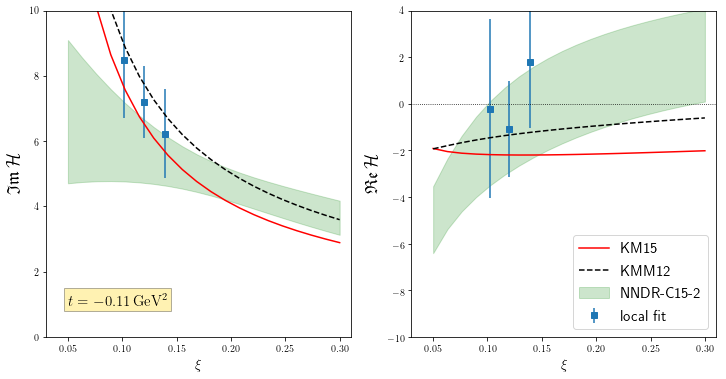

In [87]:
fig = makefig()

This is to be compared with Nature fig:

![fig2a](img/nat-fig2a.png "Nature Fig 2a -t = 0.11 GeV^2")

In [88]:
xis, pts, CFFvals, CFFerrs = makefit(1,3)

-- Bin:  0 .. 

FCN = 0.4004412921932343 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 4.077021187748323e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,7.88858,1.68307,,,,,No
1,pReH,-2.25393,2.92565,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 1 .. 

FCN = 1.4003326329683048 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 2.544564520809062e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,6.02401,0.976748,,,,,No
1,pReH,-1.08433,1.65839,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 2 .. 

FCN = 3.7737355053983324 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 6.818600864930359e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.52108,1.15657,,,,,No
1,pReH,0.0697814,2.14757,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes



 chisq/ndof = 5.6/9


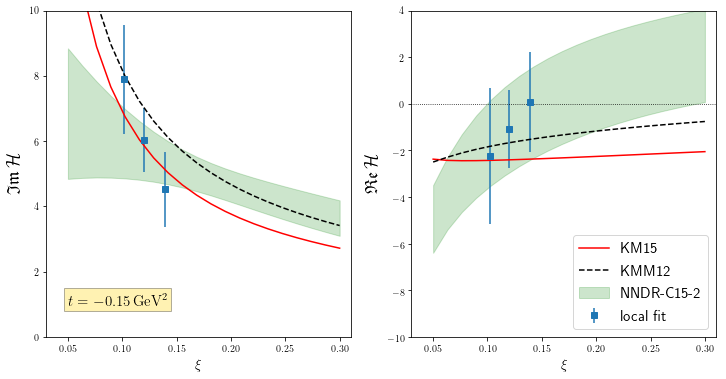

In [89]:
fig = makefig()

![fig1](img/nat-fig1.png "Nature Fig 2a -t = 0.15 GeV^2")

In [90]:
xis, pts, CFFvals, CFFerrs = makefit(2,6)

-- Bin:  0 .. 

FCN = 1.7914624494395177 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 4.476986018072975e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.91965,1.81527,,,,,No
1,pReH,-1.89746,2.18906,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 1 .. 

FCN = 2.1178656657343717 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 2.717102718739302e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.51946,1.03541,,,,,No
1,pReH,-2.23513,1.4206,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 2 .. 

FCN = 1.930651116188657 
 TOTAL NCALL = 42 
 NCALLS = 42 
 
 
 EDM = 8.132199274378233e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.61491,0.999283,,,,,No
1,pReH,0.140443,1.68308,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 3 .. 

FCN = 1.2970900732256543 
 TOTAL NCALL = 47 
 NCALLS = 47 
 
 
 EDM = 8.95296952415764e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.37991,1.25233,,,,,No
1,pReH,0.184263,2.29582,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 4 .. 

FCN = 0.4192887673743997 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 1.2978390529022613e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.55474,1.20377,,,,,No
1,pReH,0.0871917,2.40374,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 5 .. 

FCN = 0.03904637249196488 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 1.560748084219646e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.8455,2.69126,,,,,No
1,pReH,-2.80676,4.97066,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes



 chisq/ndof = 7.6/18


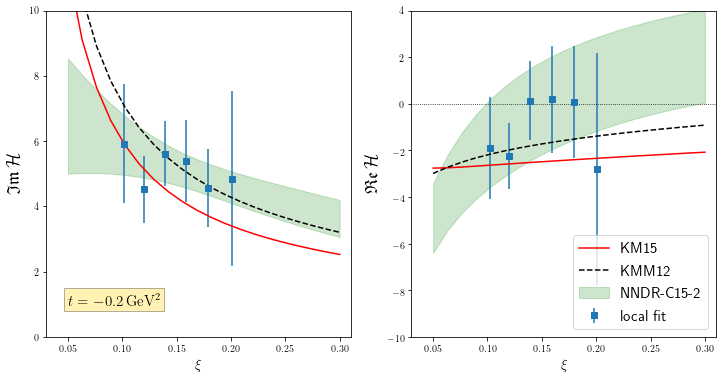

In [91]:
fig = makefig()

In [92]:
fig.savefig('figs/nat_0.2.png')

![fig2b](img/nat-fig2b.png "Nature Fig 2b: -t = 0.20 GeV^2")

In [93]:
xis, pts, CFFvals, CFFerrs = makefit(3,7)

-- Bin:  0 .. 

FCN = 0.39631574248805224 
 TOTAL NCALL = 39 
 NCALLS = 39 
 
 
 EDM = 1.1589207567059045e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.77095,1.70984,,,,,No
1,pReH,-3.78654,1.93228,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 1 .. 

FCN = 1.0097336815131845 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 1.3558371957537632e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.3627,0.973241,,,,,No
1,pReH,-1.87598,1.32285,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 2 .. 

FCN = 2.4834842406081066 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 1.971696085526779e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.42318,1.14531,,,,,No
1,pReH,-1.25946,1.42298,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 3 .. 

FCN = 2.026239243205978 
 TOTAL NCALL = 47 
 NCALLS = 47 
 
 
 EDM = 9.617602834486254e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.88252,1.12149,,,,,No
1,pReH,-1.08191,1.88809,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 4 .. 

FCN = 0.7812472295547159 
 TOTAL NCALL = 47 
 NCALLS = 47 
 
 
 EDM = 3.19917425175435e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,3.07972,1.3521,,,,,No
1,pReH,0.187572,2.39914,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 5 .. 

FCN = 0.04027351104125883 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 4.45302390886294e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,3.96787,1.47853,,,,,No
1,pReH,0.718383,2.73809,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 6 .. 

FCN = 0.006291408186143095 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 1.3864587779041384e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.79087,1.88803,,,,,No
1,pReH,0.132224,4.18344,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes



 chisq/ndof = 6.7/16


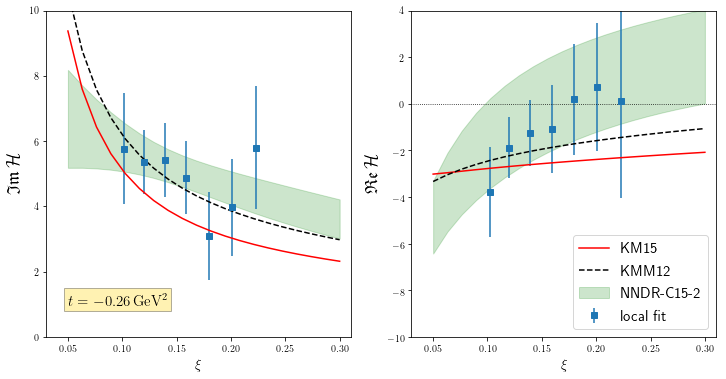

In [94]:
fig = makefig()

![fig3a](img/nat-fig3a.png "Nature Fig 3a -t = 0.26 GeV^2")

In [95]:
xis, pts, CFFvals, CFFerrs = makefit(4,8)

-- Bin:  0 .. 

FCN = 0.656026957615662 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 2.1826262615807593e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,5.86379,1.49384,,,,,No
1,pReH,-2.63197,1.44278,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 1 .. 

FCN = 1.9077740729691228 
 TOTAL NCALL = 48 
 NCALLS = 48 
 
 
 EDM = 2.1321385049561373e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.54437,1.12497,,,,,No
1,pReH,-2.42402,1.2812,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 2 .. 

FCN = 3.9833714300211542 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 3.91514236453528e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.50963,1.06856,,,,,No
1,pReH,-1.86263,1.40846,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 3 .. 

FCN = 1.457837118243149 
 TOTAL NCALL = 54 
 NCALLS = 54 
 
 
 EDM = 3.148306922517797e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,3.68538,1.13126,,,,,No
1,pReH,-1.89382,1.16549,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 4 .. 

FCN = 0.6700758342700749 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 1.744960518964007e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,3.87019,1.41734,,,,,No
1,pReH,0.0690325,2.34531,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 5 .. 

FCN = 0.4005476629626339 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 2.2471553793499186e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,4.05703,1.42963,,,,,No
1,pReH,0.600785,3.21513,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 6 .. 

FCN = 0.1158184681294755 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 2.26904329392628e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,2.09651,1.807,,,,,No
1,pReH,1.6017,4.27414,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes


 7 .. 

FCN = 0.16244718584488801 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 1.5604972599819507e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,pImH,2.77071,1.51465,,,,,No
1,pReH,-2.79563,2.96922,,,,,No
2,pImHt,0,1,,,,,Yes
3,pReHt,0,1,,,,,Yes
4,pImE,0,1,,,,,Yes
5,pReE,0,1,,,,,Yes
6,pImEt,0,1,,,,,Yes
7,pReEt,0,1,,,,,Yes



 chisq/ndof = 9.4/17


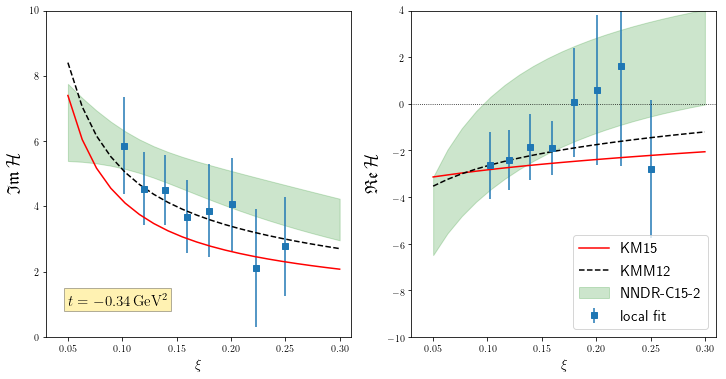

In [96]:
fig = makefig()

![fig3b](img/nat-fig3b.png "Nature Fig 3b: -t = 0.34 GeV^2")

Local fits presented here are consistent with neural net results from previous sections. They have smaller (less negative) ReH, and with significantly larger uncertainty than in Nature paper (and there is also upward shift!). Not all of the discrepancies can be ascribed to the choice BSD vs BSA.

# (Appendix) Plot for inclusion in the paper

In [97]:
a = np.loadtxt('img/natfig_20a.dat')
alup = a[:24]
aldn = a[24:]

In [98]:
b = np.loadtxt('img/natfig_20b.dat')
lup = b[:29]
ldn = b[29:]

In [99]:
aJLBup = InterpolatedUnivariateSpline(alup[:,0], alup[:,1], k=1)
aJLBdn = InterpolatedUnivariateSpline(aldn[:,0], aldn[:,1], k=1)

In [100]:
JLBup = InterpolatedUnivariateSpline(lup[:,0], lup[:,1], k=1)
JLBdn = InterpolatedUnivariateSpline(ldn[:,0], ldn[:,1], k=1)

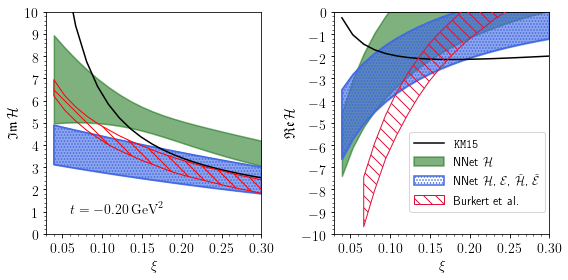

In [101]:
NPTS = 20
NN2 = True # Do we plot second NN?
ex_pt = data[25][4].copy()
ex_pt.t = -0.2
ex_pt.Q2 = 4.

TH = db['KM15']
THNN = dbn['NNDR-C15-2']
THNN.name = r'NNet $\mathcal{H}$'
THNN2 = dbn['NNDR-C15-8']
THNN2.name = r'NNet $\mathcal{H}$, $\mathcal{E}$, $\tilde{\mathcal{H}}$, $\tilde{\mathcal{E}}$'


plt.close('all')
RASTER = False
rorder = -3000
if RASTER:
    rorder = 1

fig, axs = plt.subplots(1, 2, sharex=True, figsize=[8,4])
axs = axs.reshape(2)
cffs = ['ImH', 'ReH']
ylims = {
        'ImH': (0, 10), 'ReH': (-10, 0),
         'ImE': (-40, 35), 'ReE': (-40, 10),
         'ImEt': (-200, 300), 'ReEt': (-150, 150),
         'ImHt': (-6, 10), 'ReHt': (-12, 12)}
for cff, (pn, ax) in zip(cffs, enumerate(axs)):
    ax.set_rasterization_zorder(rorder)
    xis = np.linspace(0.04, 0.30, NPTS)
    ys = []
    ysNN = []
    ysNNerr = []
    ysNN2 = []
    ysNN2err = []
    ysJLB = []
    ysJLBerr = []
    for xi in xis:
        pt = ex_pt.copy()
        pt.xB = 2*xi/(1+xi)
        del pt.W
        del pt.xi
        del pt.tm
        utils.fill_kinematics(pt)
        
        TH.m.g.newcall = 1
        y = getattr(TH.m, cff)(pt)
        ys.append(y)
        
        yall = getattr(THNN.m, cff)(pt)
        ysNN.append(yall.mean())
        ysNNerr.append(yall.std())
        
        if NN2:
            yall = getattr(THNN2.m, cff)(pt)
            ysNN2.append(yall.mean())
            ysNN2err.append(yall.std())
            
    ysNN = np.array(ysNN)
    ysNNerr = np.array(ysNNerr)
    
    if NN2:
        ysNN2 = np.array(ysNN2)
        ysNN2err = np.array(ysNN2err)

    ax.plot(xis, ys, 'k-', label=r'\texttt{%s}' % TH.name)

    ax.fill_between(xis, ysNN-ysNNerr, ysNN+ysNNerr,
                    label=r'{}'.format(THNN.name), 
                    color = 'darkgreen', alpha = 0.5,
                    # hatch = '\\\\', facecolor='none', edgecolor='blue', 
                    linewidth=1.5, zorder=0)
    if NN2:
        ax.fill_between(xis, ysNN2-ysNN2err, ysNN2+ysNN2err, #alpha=0.3,
                    #label=r'{}'.format(THNN2.name),
                    color = 'royalblue', alpha = 0.6,
                    #hatch = '////', edgecolor='royalblue', facecolor='royalblue',
                    linewidth=1.5, zorder=0)
        ax.fill_between(xis, ysNN2-ysNN2err, ysNN2+ysNN2err, #alpha=0.3,
                    label=r'{}'.format(THNN2.name),
                    #color = 'royalblue', alpha = 0.6,
                    hatch = '....', edgecolor='royalblue', facecolor='none',
                    linewidth=1.5, zorder=1)
    
    if pn == 1:
        ax.fill_between(xis[2:-4], JLBdn(xis[2:-4]), JLBup(xis[2:-4]), #alpha=0.3,
                    label=r'Burkert et al.', #color='red',
                    hatch = '\\\\', facecolor='none',
                    edgecolor='crimson', linewidth=1.0,
                        zorder=3)
    else:
        ax.fill_between(xis, aJLBdn(xis), aJLBup(xis), #alpha=0.3,
                    label=r'Burkert et al.', #color='red', 
                    hatch = '\\\\', facecolor='none',
                    edgecolor='red', linewidth=1.0,
                        zorder=3) 
        
    ax.set_xlim(0.03, 0.3)
    ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.05)) 
    ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.01)) 
    ax.yaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(1.)) 
    ax.yaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.2)) 
    s1 = r'$t = {:.2f}\, {{\rm GeV}}^2$'.format(ex_pt.t)
    ax.set_ylabel(toTeX[cff], fontsize=14)
    ax.set_ylim(*ylims[cff])
    ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
    if pn >= 0:
        ax.set_xlabel(r'$\xi$', fontsize=14)
    if pn == 0:
        ax.text(0.06, 1, s1, fontsize=14)
        #axs[pn].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.01))
    if pn == 1:
        #ax.set_ylabel(r'$\mathfrak{Im}\,\tilde{\cal H}$', fontsize=12)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc=(0.35, 0.1),
                  handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout(h_pad=0.) 
fig.savefig('figs/CFFs.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

Final version of figure with fits to BSA instead of BSD (as requested by one referee), and with DM09(Delta=0) line, as requested by another referee:

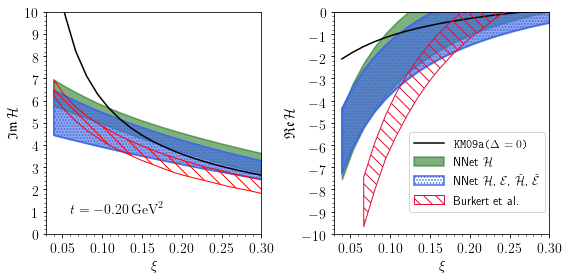

In [102]:
NPTS = 20
NN2 = True # Do we plot second NN?
ex_pt = data[25][4].copy()
ex_pt.t = -0.2
ex_pt.Q2 = 4.

TH = th09azero
THNN = dbn['NNDR-C15-BSA-2']
THNN.name = r'NNet $\mathcal{H}$'
THNN2 = dbn['NNDR-C15-BSA-8']
THNN2.name = r'NNet $\mathcal{H}$, $\mathcal{E}$, $\tilde{\mathcal{H}}$, $\tilde{\mathcal{E}}$'


plt.close('all')
RASTER = False
rorder = -3000
if RASTER:
    rorder = 1

fig, axs = plt.subplots(1, 2, sharex=True, figsize=[8,4])
axs = axs.reshape(2)
cffs = ['ImH', 'ReH']
ylims = {
        'ImH': (0, 10), 'ReH': (-10, 0),
         'ImE': (-40, 35), 'ReE': (-40, 10),
         'ImEt': (-200, 300), 'ReEt': (-150, 150),
         'ImHt': (-6, 10), 'ReHt': (-12, 12)}
for cff, (pn, ax) in zip(cffs, enumerate(axs)):
    ax.set_rasterization_zorder(rorder)
    xis = np.linspace(0.04, 0.30, NPTS)
    ys = []
    ysNN = []
    ysNNerr = []
    ysNN2 = []
    ysNN2err = []
    ysJLB = []
    ysJLBerr = []
    for xi in xis:
        pt = ex_pt.copy()
        pt.xB = 2*xi/(1+xi)
        del pt.W
        del pt.xi
        del pt.tm
        utils.fill_kinematics(pt)
        
        if 'g' in TH.m.__dict__:
            TH.m.g.newcall = 1
        y = getattr(TH.m, cff)(pt)
        ys.append(y)
        
        yall = getattr(THNN.m, cff)(pt)
        ysNN.append(yall.mean())
        ysNNerr.append(yall.std())
        
        if NN2:
            yall = getattr(THNN2.m, cff)(pt)
            ysNN2.append(yall.mean())
            ysNN2err.append(yall.std())
            
    ysNN = np.array(ysNN)
    ysNNerr = np.array(ysNNerr)
    
    if NN2:
        ysNN2 = np.array(ysNN2)
        ysNN2err = np.array(ysNN2err)

    ax.plot(xis, ys, 'k-', label=r'\texttt{%s}' % TH.name)

    ax.fill_between(xis, ysNN-ysNNerr, ysNN+ysNNerr,
                    label=r'{}'.format(THNN.name), 
                    color = 'darkgreen', alpha = 0.5,
                    # hatch = '\\\\', facecolor='none', edgecolor='blue', 
                    linewidth=1.5, zorder=0)
    if NN2:
        ax.fill_between(xis, ysNN2-ysNN2err, ysNN2+ysNN2err, #alpha=0.3,
                    #label=r'{}'.format(THNN2.name),
                    color = 'royalblue', alpha = 0.6,
                    #hatch = '////', edgecolor='royalblue', facecolor='royalblue',
                    linewidth=1.5, zorder=0)
        ax.fill_between(xis, ysNN2-ysNN2err, ysNN2+ysNN2err, #alpha=0.3,
                    label=r'{}'.format(THNN2.name),
                    #color = 'royalblue', alpha = 0.6,
                    hatch = '....', edgecolor='royalblue', facecolor='none',
                    linewidth=1.5, zorder=1)
    
    if pn == 1:
        ax.fill_between(xis[2:-4], JLBdn(xis[2:-4]), JLBup(xis[2:-4]), #alpha=0.3,
                    label=r'Burkert et al.', #color='red',
                    hatch = '\\\\', facecolor='none',
                    edgecolor='crimson', linewidth=1.0,
                        zorder=3)
    else:
        ax.fill_between(xis, aJLBdn(xis), aJLBup(xis), #alpha=0.3,
                    label=r'Burkert et al.', #color='red', 
                    hatch = '\\\\', facecolor='none',
                    edgecolor='red', linewidth=1.0,
                        zorder=3) 
        
    ax.set_xlim(0.03, 0.3)
    ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.05)) 
    ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.01)) 
    ax.yaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(1.)) 
    ax.yaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.2)) 
    s1 = r'$t = {:.2f}\, {{\rm GeV}}^2$'.format(ex_pt.t)
    ax.set_ylabel(toTeX[cff], fontsize=14)
    ax.set_ylim(*ylims[cff])
    ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
    if pn >= 0:
        ax.set_xlabel(r'$\xi$', fontsize=14)
    if pn == 0:
        ax.text(0.06, 1, s1, fontsize=14)
        #axs[pn].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.01))
    if pn == 1:
        #ax.set_ylabel(r'$\mathfrak{Im}\,\tilde{\cal H}$', fontsize=12)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc=(0.35, 0.1),
                  handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout(h_pad=0.) 
fig.savefig('figs/CFFsV2.pdf', bbox_inches='tight', transparent=True, pad_inches=0)